#1) Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from matplotlib.gridspec import GridSpec

In [ ]:
series = pd.read_csv("monthly-boston-armed-robberies-j.csv")['Count']

**Строим графики и проводим тест Дики-Фуллера**

In [ ]:
def Dickey_Fuller(y):
  """"Функция принимает на вход временной ряд
  и выводит на печать значения теста Дики-Фуллера 
  """
  result = adfuller(y)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    print()
  if result[1] > 0.05:
    print('Временной ряд не является стационарным')
  else:
    print('Стационарный временной ряд') 

In [ ]:
def grafs(series):
    """Функция для отображения графиков Time series, ACF, PACF """
    fig = plt.figure(figsize=(12, 8), dpi = 120)
    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series, color='blue')
    ax1.set_title('Time series')
    ax1.set_facecolor('lightgray')
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[1, 0])
    plot_acf(series, color='green',ax=ax2)
    ax2.set_title('Autocorrelation Function (ACF)')
    ax2.set_facecolor('lightyellow')
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, 1])
    plot_pacf(series, color='red', ax=ax3)
    ax3.set_title('Partial Autocorrelation Function (PACF)')
    ax3.set_facecolor('lightblue')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

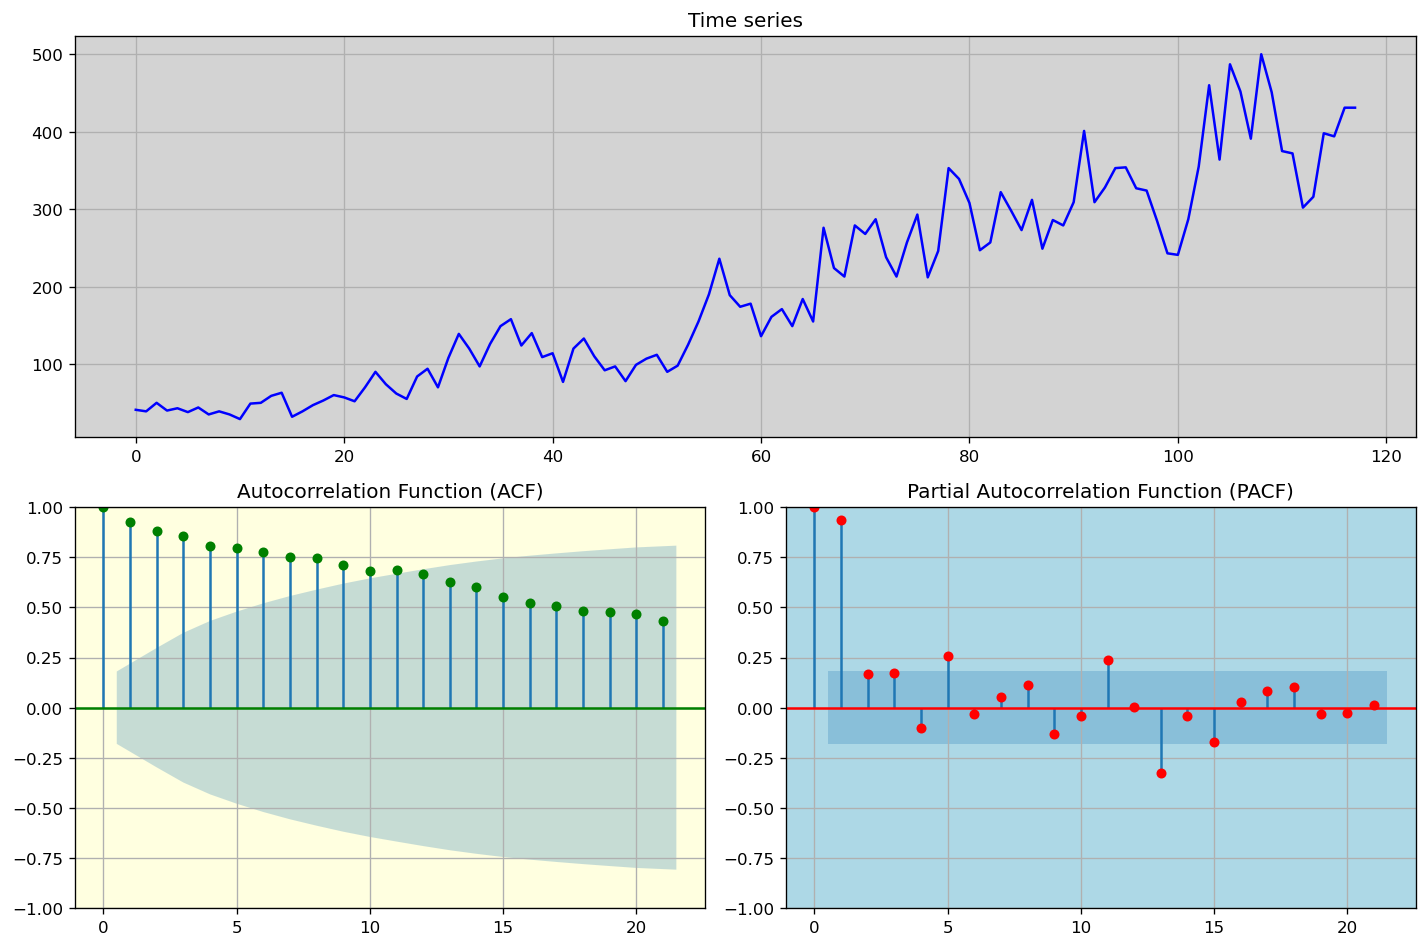

In [ ]:
grafs(series)

In [ ]:
Dickey_Fuller(series)

ADF Statistic: 1.001102
p-value: 0.994278
Critical Values:
	1%: -3.494

	5%: -2.889

	10%: -2.582

Временной ряд не является стационарным


**Делаем временной ряд стационарным**

In [ ]:
stat_series = series.diff().dropna() # Дифференцирование

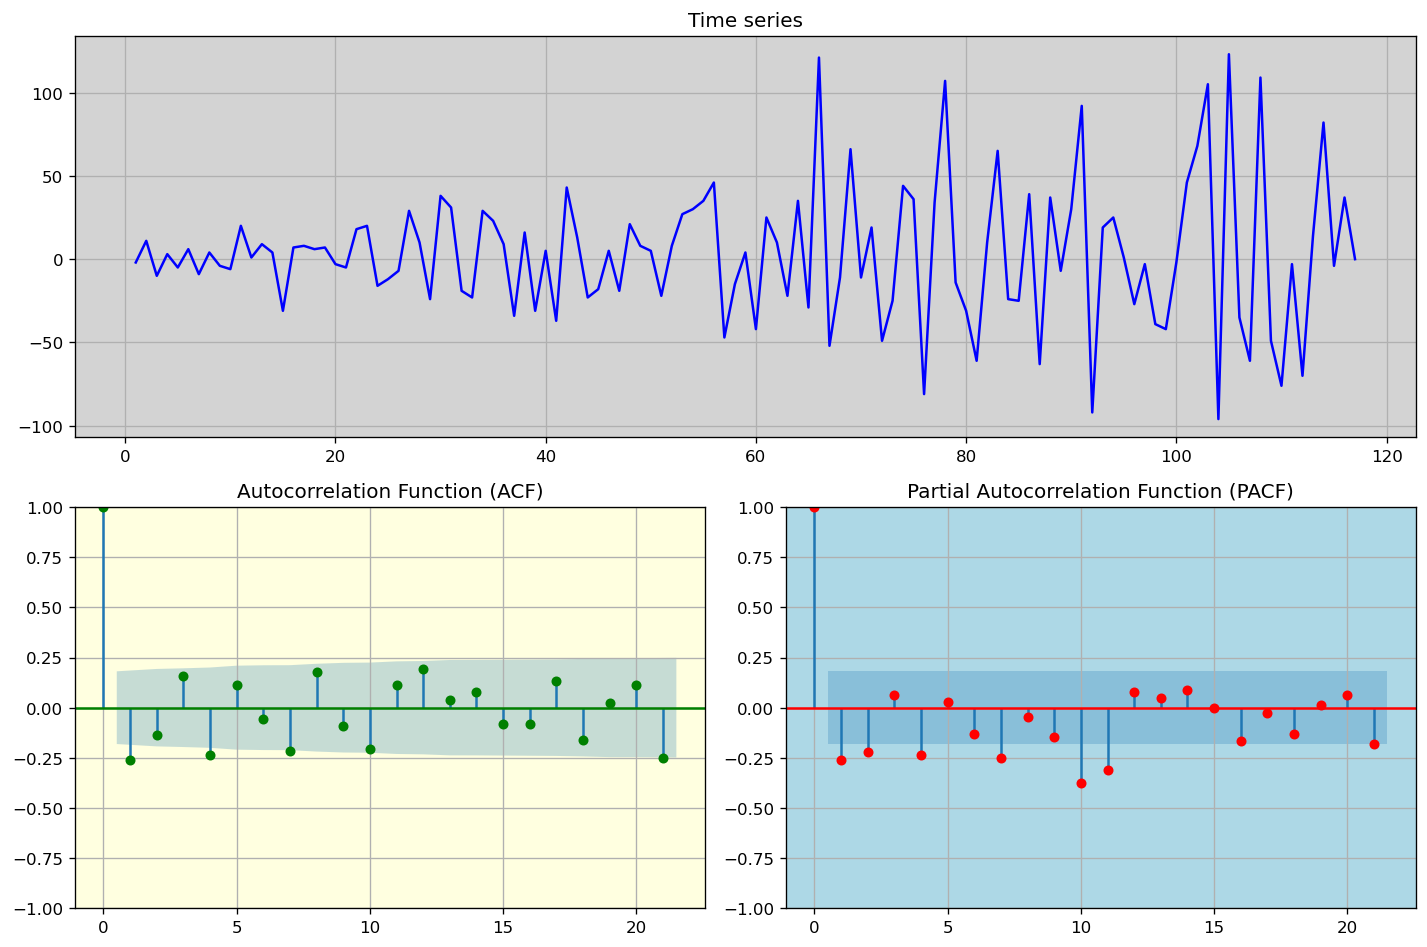

In [ ]:
grafs(stat_series)

In [ ]:
Dickey_Fuller(stat_series)

ADF Statistic: -7.428564
p-value: 0.000000
Critical Values:
	1%: -3.494

	5%: -2.889

	10%: -2.582

Стационарный временной ряд


#Приблизьте оба варианта моделями из класса MA.

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
def train_test_split(series, train_size = 0.8):
    """Функция делит временной ряд на тренировочные
    и тестовые данные, по умолчанию тренировочные данные 80%, 
    тестовые данные 20%"""
    train_size = int(len(series) * train_size)
    train, test = series[:train_size], series[train_size:]
    return train, test

##Метод скользящего среднего (Moving Average, MA)

Метод скользящего среднего (Moving Average, MA) - это один из простых методов анализа временных рядов, который используется для сглаживания данных и выявления общих трендов. Он основан на вычислении среднего значения для последовательных подмножеств данных в заданном окне (обычно фиксированного размера).

Основная идея метода скользящего среднего заключается в замене каждого значения временного ряда средним значением его соседних точек в окне. Это позволяет уменьшить шумы и колебания, а также выделить более гладкие компоненты временного ряда, такие как тренды и сезонные изменения.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [ ]:
class Moving_Average:

  def __init__(self, train, test, window_size):
    self.train = train
    self.test = test
    self.window_size = window_size
    self.n_pred = len(test)

  def predict(self,window_size= None):
    """Функция предсказывающая последующие значения 
    временного ряда(series) на основе метода скользящего среднего 
    с размером окна n и количеством предсказанных точек n_preds """
    if window_size is None:
        window_size = self.window_size
    new_series = self.train.copy()
    for _ in range(self.n_pred):
        new_series = new_series.append(pd.Series([new_series[-window_size:].mean()]), ignore_index=True)
    return new_series 
  def ma_loss(self, window_size= None):
    """Функция возвращает MSE предсказанных значений и значений тестовой выборки"""
    if window_size is None:
        window_size = self.window_size  
    result = self.predict(window_size)
    predictions = result[-self.n_pred:]
    error = mean_squared_error(predictions, test)
    return error 
  def find_optimal_window_size(self):
    """Функция подбирает оптимальный размер окна скользящего среднего
    и MSE с оптимальным размером окна в виде словаря"""
    opt_window_size = 0
    mse = np.inf
    for i in range(1,50):
        error = self.ma_loss(i)
        if error < mse:
          mse = error
          opt_window_size = i   
    return {'optimal window size':opt_window_size, 'MSE':mse}      


**Нестационарный временной ряд**

In [ ]:
train, test = train_test_split(series, 0.95)

In [ ]:
print(f'len train: {len(train)}, len test: {len(test)}')

len train: 112, len test: 6


In [ ]:
MA = Moving_Average(train, test, 3)

In [ ]:
MA.ma_loss()

3030.613899128343

In [ ]:
MA.find_optimal_window_size()

{'optimal window size': 15, 'MSE': 1700.8533005070037}

In [ ]:
series_pred = MA.predict(15)

In [ ]:
def plot_pred_test(series,series_pred):
    """Функция для отображения предсказанных значений в сравнении с реальными """
    plt.figure(figsize=(12, 6), dpi = 120)
    plt.xticks(range(0, 120, 5))
    plt.plot(series_pred, color='green', linewidth='3', label='Pred')
    plt.plot(series, color='blue', linewidth='3', label='Real', alpha = 0.5)
    plt.axvline(x= 111, color='red', linestyle='--', label='Разделение на реальные и предсказанные значения')
    plt.grid()
    plt.legend()
    plt.show()

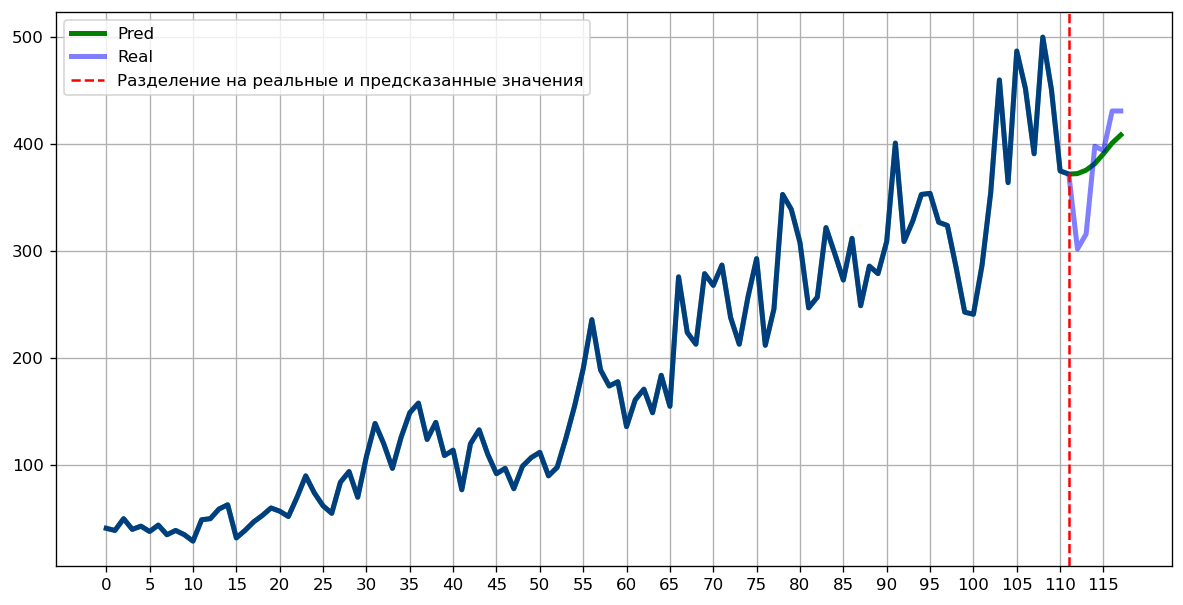

In [ ]:
plot_pred_test(series,series_pred)# предсказанные значеня начинаются со 113

**Стационарный временной ряд**

In [ ]:
st_train, st_test = train_test_split(stat_series, 0.95)

In [ ]:
print(f'len train: {len(st_train)}, len test: {len(st_test)}')

len train: 111, len test: 6


In [ ]:
MA_st = Moving_Average(st_train, st_test, 3)

In [ ]:
MA_st.ma_loss()

174638.7381989095

In [ ]:
MA_st.find_optimal_window_size()

{'optimal window size': 14, 'MSE': 140580.24424776153}

In [ ]:
st_series_pred = MA_st.predict(14)

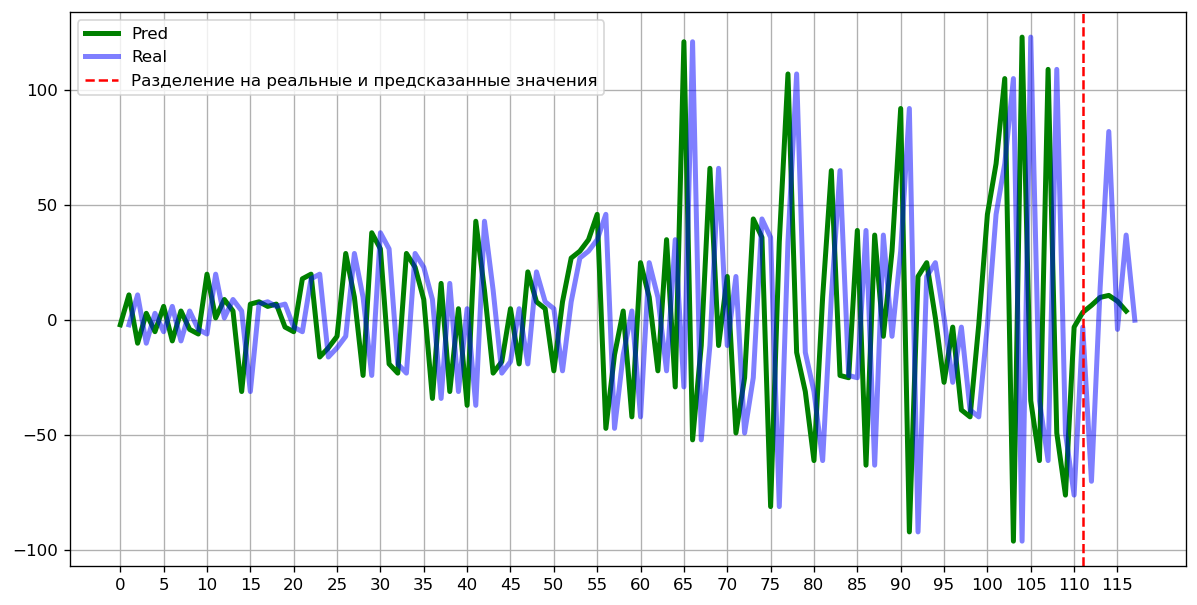

In [ ]:
plot_pred_test(stat_series,st_series_pred)# предсказанные значения начинаются со 112


##Взвешенное скользящее среднее (Weighted Moving Average)

Взвешенное скользящее среднее (Weighted Moving Average) - это метод анализа временных рядов, который использует взвешенную комбинацию предыдущих значений ряда для прогнозирования следующего значения. В отличие от простого скользящего среднего, где все предыдущие значения имеют одинаковый вес, взвешенное скользящее среднее присваивает разные веса различным наблюдениям.

Каждому наблюдению в ряду присваивается вес, который определяет его значимость при расчете среднего значения. Веса могут быть заданы заранее или определены в процессе анализа с использованием оптимизации или других методов. Обычно веса выбираются таким образом, чтобы отразить важность каждого значения в предсказании будущих значений.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [ ]:
class WeightedMovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.weights = None
    
    def fit(self, data):
        """Функция для подбора весов взвешенноего скользящего среднего"""
        loss_func = lambda weights: self.weighted_average_loss(weights, data)
        initial_weights = np.linspace(0,1,self.window_size)  # Начальные значения весов (равномерное распределение)
        bounds = [(0, 1)] * self.window_size  # Ограничения для значений весов (от 0 до 1)
        result = minimize(loss_func, initial_weights, bounds=bounds, method='SLSQP')
        self.weights = result.x
    
    def predict(self, data, future_steps=1):
        """Функция предсказывает последующие значения в количестве(future_steps)"""
        predictions = []
        for _ in range(future_steps):
            if len(data) < self.window_size:
                break
            current_window = data[-self.window_size:]
            weighted_average = np.average(current_window, weights=self.weights)
            predictions.append(weighted_average)
            data = np.append(data, weighted_average)
        return predictions
    
    def weighted_average_loss(self, weights, data):
        """Функция потерь"""
        weighted_average = np.average(data[-self.window_size:], weights=weights)
        loss = np.mean((weighted_average - data[-self.window_size:]) ** 2)
        return loss




**Нестационарный временной ряд**

In [ ]:
wma = WeightedMovingAverage(3)

In [ ]:
wma.fit(train)

In [ ]:
future_steps = len(test)

In [ ]:
predictions = wma.predict(train, future_steps)

In [ ]:
mean_squared_error(test,predictions)

3030.6139022700354

In [ ]:
pred_series = train.append(pd.Series(predictions), ignore_index=True)

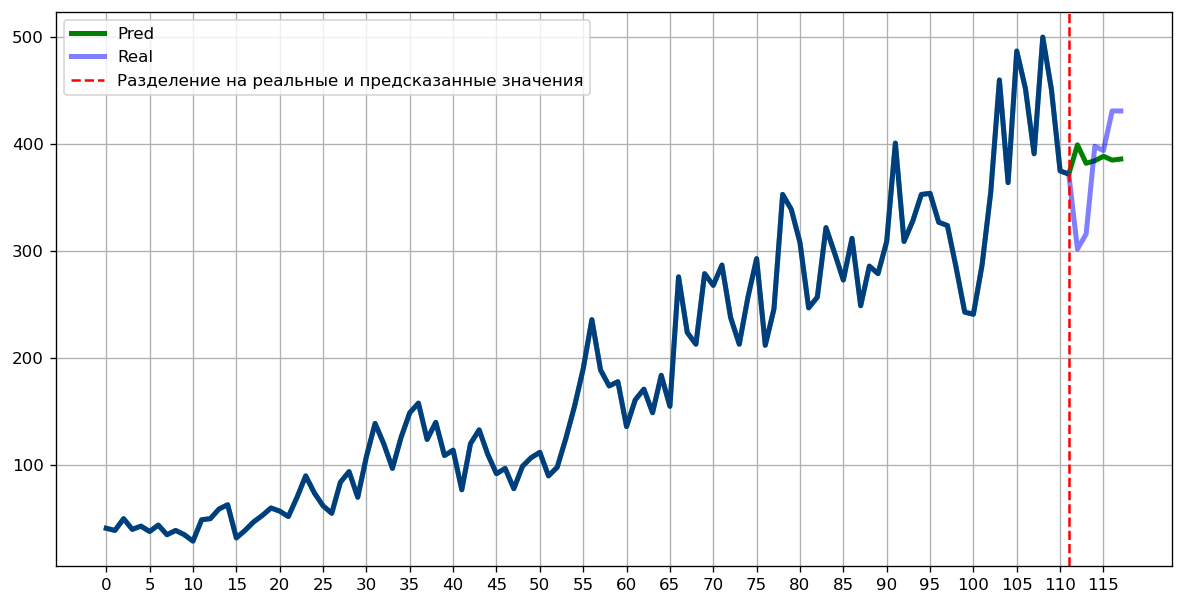

In [ ]:
plot_pred_test(series,pred_series) # предсказанные значеня начинаются со 113

**Стационарный временной ряд**

In [ ]:
wma_stat = WeightedMovingAverage(28)

In [ ]:
wma_stat.fit(st_train)

In [ ]:
future_steps = len(st_test)

In [ ]:
predictions_st = wma_stat.predict(st_train, future_steps)

In [ ]:
mean_squared_error(st_test,predictions_st)

2169.429714633737

In [ ]:
st_series_pred = st_train.append(pd.Series(predictions_st), ignore_index=True)

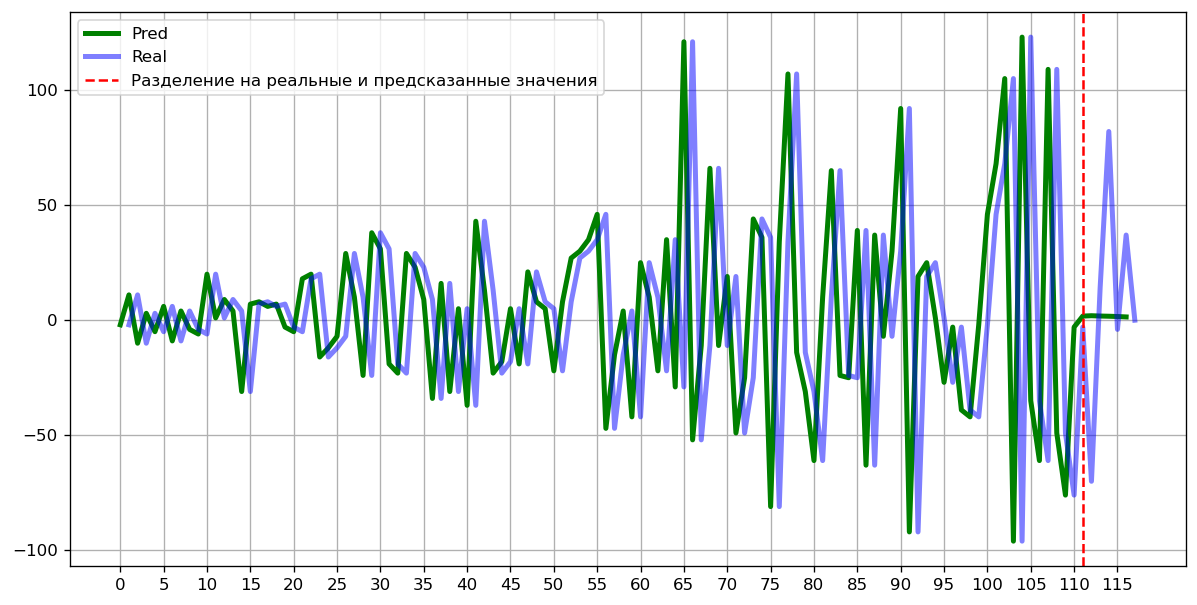

In [ ]:
plot_pred_test(stat_series,st_series_pred)# предсказанные значеня начинаются со 112

##Экспоненциальное сглаживание(Exponential Smoothing)

Экспоненциальное сглаживание - это метод анализа и прогнозирования временных рядов, который использует взвешенное усреднение исторических данных с учетом их экспоненциально убывающей важности. Он основан на предположении, что более новые наблюдения имеют большую значимость для прогнозирования, чем более старые.

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

In [ ]:
class ExponentialSmoothing:
    def __init__(self):
        self.alpha = None
    
    def exponential_smoothing(self, data, alpha):
        smoothed_data = [data[0]]  # Инициализация сглаженного ряда первым значением исходного ряда
        for i in range(1, len(data)):
            smoothed_value = alpha * data[i] + (1 - alpha) * smoothed_data[-1]  # Расчет сглаженного значения
            smoothed_data.append(smoothed_value)
        return np.array(smoothed_data)
    
    def mse_loss(self, alpha, data):
        smoothed_data = self.exponential_smoothing(data, alpha)  # Сглаживание данных с заданным параметром alpha
        loss = np.mean((smoothed_data - data) ** 2)  # Вычисление среднеквадратичной ошибки
        return loss
    
    def fit(self, data):
        best_alpha = None
        best_loss = float('inf')
        for alpha in np.arange(0, 1, 0.01):  # Перебор значений alpha от 0 до 1 с шагом 0.01
            loss = self.mse_loss(alpha, data)
            if loss < best_loss:
                best_loss = loss
                best_alpha = alpha
        self.alpha = best_alpha
    
    def forecast(self, data, steps):
        if self.alpha is None:
            raise ValueError("Model has not been fitted. Please call 'fit' method first.")
        last_value = data[-1:]
        smoothed_data = self.exponential_smoothing(data, self.alpha)  # Сглаживание данных
        forecast = []  # Инициализация прогноза
        for _ in range(steps):
            forecast_value = self.alpha * last_value + (1 - self.alpha) * smoothed_data[-1]  # Расчет прогнозного значения
            forecast.append(float(forecast_value))
            smoothed_data = np.append(smoothed_data, forecast_value)  # Обновление сглаженных данных
        return np.array(forecast)

**Нестационарный временной ряд**

In [ ]:
es = ExponentialSmoothing()

In [ ]:
es.fit(train)

In [ ]:
forecast = es.forecast(train, len(test))

In [ ]:
forecast

array([372.00037648, 372.00000376, 372.00000004, 372.        ,
       372.        , 372.        ])

In [ ]:
mean_squared_error(test, forecast)

2693.0088544843825

In [ ]:
pred_series = train.append(pd.Series(forecast), ignore_index=True)

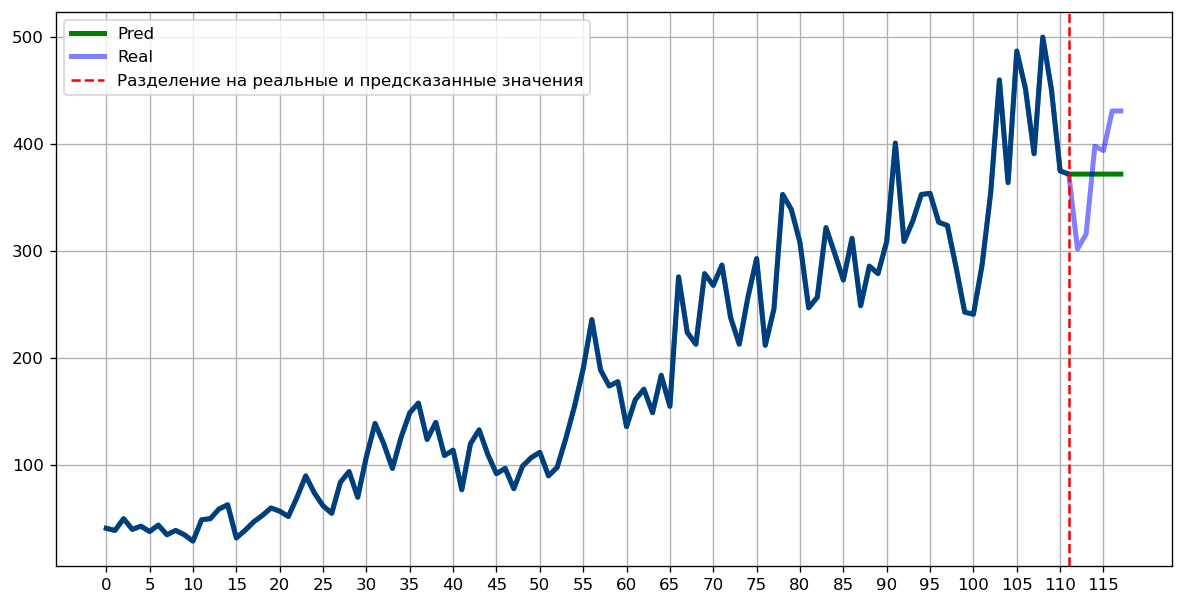

In [ ]:
plot_pred_test(series,pred_series)# предсказанные значеня начинаются со 113

**Стационарный временной ряд**

In [ ]:
st_es = ExponentialSmoothing()

In [ ]:
st_es.fit(np.array(st_train))

In [ ]:
st_forecast = es.forecast(np.array(st_train), len(test))

In [ ]:
mean_squared_error(st_test, st_forecast)

2268.6713793698423

In [ ]:
st_series_pred = st_train.append(pd.Series(forecast), ignore_index=True)

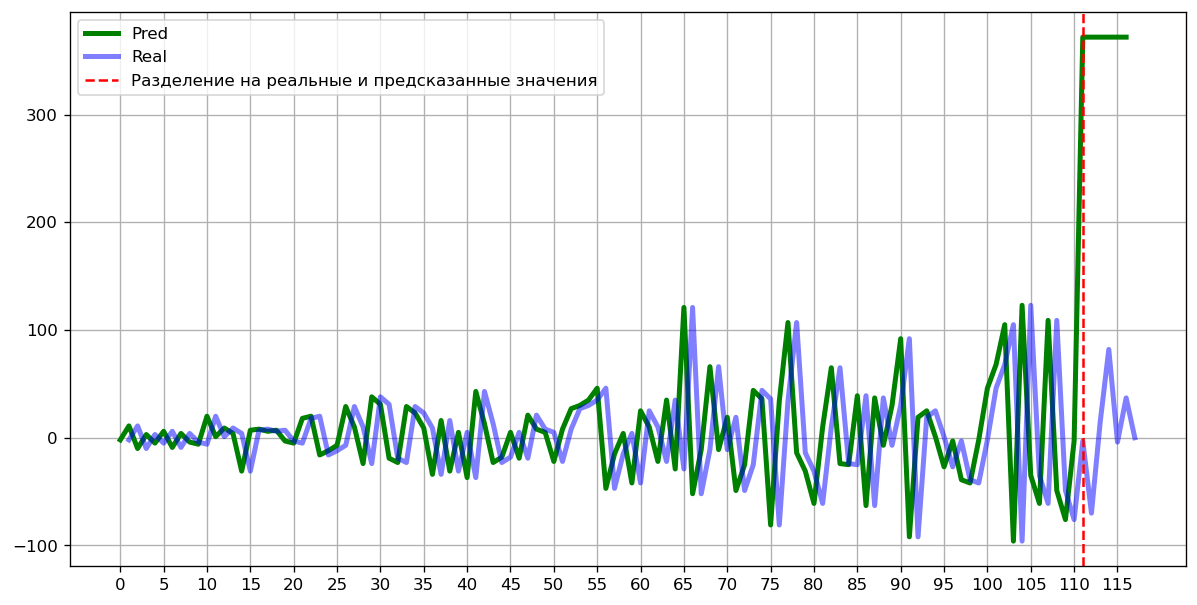

In [ ]:
plot_pred_test(stat_series,st_series_pred)# предсказанные значеня начинаются со 112

##Двойное экспоненциальное сглаживание (Double Exponential Smoothing) 

Двойное экспоненциальное сглаживание (Double Exponential Smoothing) - это метод прогнозирования временных рядов, который учитывает как уровень (level), так и тренд (trend) данных. Он является расширением простого экспоненциального сглаживания (Simple Exponential Smoothing), который учитывает только уровень.

Двойное экспоненциальное сглаживание состоит из двух компонент: уровня и тренда. Уровень представляет собой сглаженное значение данных, а тренд - изменение уровня со временем. Основная идея метода заключается в том, что тренд может быть смоделирован с помощью экспоненциального сглаживания, а затем использован для прогнозирования будущих значений.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [ ]:
class DoubleExponentialSmoothing:
    def __init__(self, data, alpha=None, beta=None):
        self.data = np.array(data)
        self.alpha = alpha
        self.beta = beta
        self.optimize_params()

    def optimize_params(self):
        # Оптимизация параметров alpha и beta
        def loss(params):
            alpha, beta = params
            smoothed_data = self.double_exponential_smoothing(alpha, beta)
            return np.mean((smoothed_data - self.data) ** 2)

        initial_guess = [0.5, 0.5]  # Начальное предположение для alpha и beta
        bounds = [(0, 1), (0, 1)]  # Ограничения для alpha и beta
        result = minimize(loss, initial_guess, bounds=bounds)
        self.alpha, self.beta = result.x

    def double_exponential_smoothing(self, alpha, beta):
        # Двойное экспонециальное сглаживание
        n = len(self.data)
        level = np.zeros(n)
        trend = np.zeros(n)

        level[0] = self.data[0]
        trend[0] = self.data[1] - self.data[0]

        for i in range(1, n):
            level[i] = alpha * self.data[i] + (1 - alpha) * (level[i-1] + trend[i-1])
            trend[i] = beta * (level[i] - level[i-1]) + (1 - beta) * trend[i-1]

        smoothed_data = level + trend
        return smoothed_data

    def forecast(self, steps):
        # Прогнозирование следующих значений
        last_level = self.data[-1]
        last_trend = self.data[-1] - self.data[-2]

        forecasted_data = []
        for i in range(steps):
            level = self.alpha * self.data[-1] + (1 - self.alpha) * (last_level + last_trend)
            trend = self.beta * (level - last_level) + (1 - self.beta) * last_trend
            forecast = level + trend
            forecasted_data.append(forecast)

            last_level = level
            last_trend = trend

        return forecasted_data

**Нестационарный временной ряд**

In [ ]:
des = DoubleExponentialSmoothing(train)

In [ ]:
forecast = des.forecast(len(test))

In [ ]:
print(f'alpha: {des.alpha}, beta: {des.beta}')

alpha: 0.9979864920669066, beta: 0.006803832846882854


In [ ]:
mean_squared_error(test, forecast)

2737.458852681608

In [ ]:
pred_series = train.append(pd.Series(forecast), ignore_index=True)

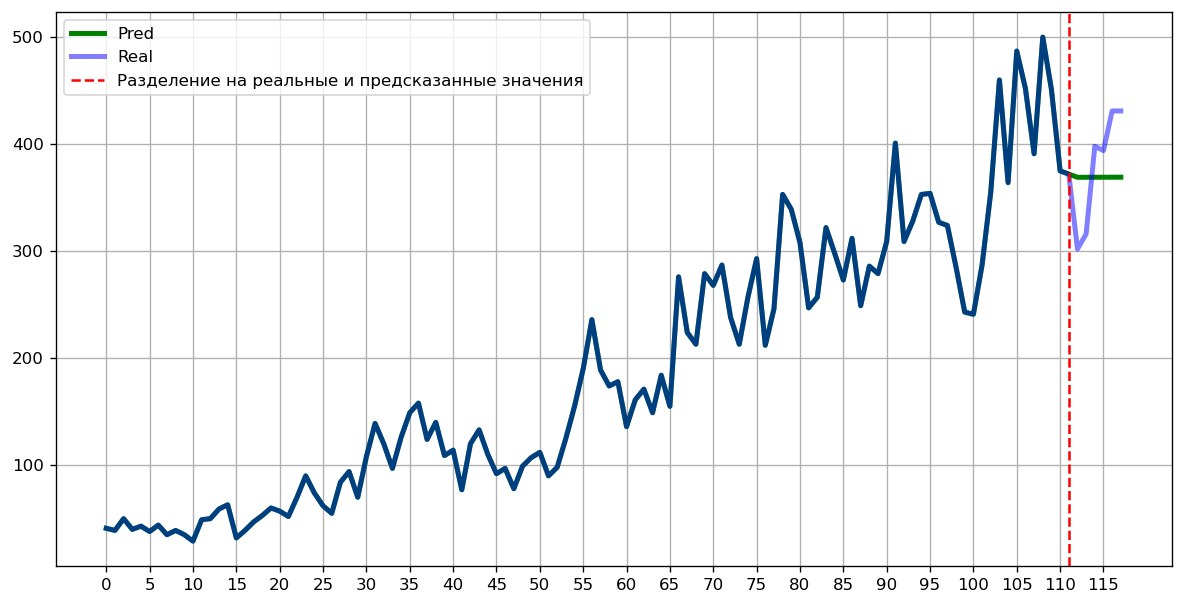

In [ ]:
plot_pred_test(series,pred_series)# предсказанные значеня начинаются со 113

**Стационарный временной ряд**

In [ ]:
st_des = DoubleExponentialSmoothing(st_train)

In [ ]:
st_forecast = st_des.forecast(len(st_test))

In [ ]:
print(f'alpha: {st_des.alpha}, beta: {st_des.beta}')

alpha: 0.9601594701356968, beta: 0.0858563724417867


In [ ]:
mean_squared_error(st_test,st_forecast)

4404.651266784432

In [ ]:
st_series_pred = st_train.append(pd.Series(st_forecast), ignore_index=True)

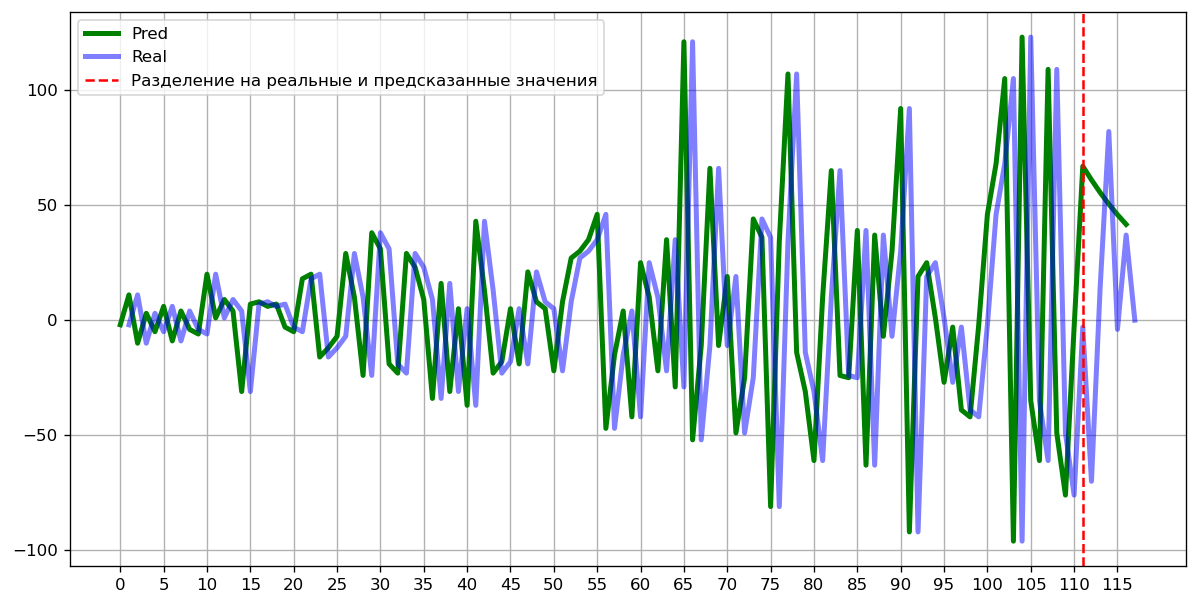

In [ ]:
plot_pred_test(stat_series,st_series_pred)# предсказанные значеня начинаются со 112

##Тройное экспоненциальное сглаживание (Triple Exponential Smoothing)

Тройное экспоненциальное сглаживание (Triple Exponential Smoothing), также известное как метод Хольта-Винтерса (Holt-Winters), является методом прогнозирования временных рядов, который учитывает уровень (level), тренд (trend) и сезонность (seasonality) данных. Он представляет собой расширение двойного экспоненциального сглаживания.

Тройное экспоненциальное сглаживание учитывает как уровень и тренд данных, так и сезонные колебания, которые повторяются в определенных интервалах времени. Он позволяет моделировать и прогнозировать временные ряды, которые обладают как трендом, так и сезонностью.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

In [ ]:
class TripleExponentialSmoothing:
    def __init__(self, alpha=None, beta=None, gamma=None):
        """
        Инициализация объекта класса тройного экспоненциального сглаживания.

        Параметры:
        - alpha: параметр сглаживания для уровня (0 <= alpha <= 1)
        - beta: параметр сглаживания для тренда (0 <= beta <= 1)
        - gamma: параметр сглаживания для сезонности (0 <= gamma <= 1)
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.seasonal_periods = None
        self.initial_level = None
        self.initial_trend = None
        self.initial_seasonal = None
        self.optimal_params = None

    def fit(self, data, seasonal_periods):
        """
        Обучение модели тройного экспоненциального сглаживания.

        Параметры:
        - data: временной ряд для обучения
        - seasonal_periods: период сезонности

        """
        self.seasonal_periods = seasonal_periods

        # Инициализация начальных значений для уровня, тренда и сезонности
        self.initial_level = np.mean(data[:self.seasonal_periods])
        self.initial_trend = (data[self.seasonal_periods] - self.initial_level) / self.seasonal_periods
        self.initial_seasonal = np.array([(data[i] - self.initial_level) / self.initial_trend for i in range(self.seasonal_periods)])

        # Определение функции потерь для оптимизации
        def loss_function(params):
            alpha, beta, gamma = params
            level = self.initial_level
            trend = self.initial_trend
            seasonal = self.initial_seasonal.copy()

            # Экспоненциальное сглаживание
            for i in range(len(data)):
                if i >= self.seasonal_periods:
                    previous_level = level
                    level = alpha * (data[i] - seasonal[i % self.seasonal_periods]) + (1 - alpha) * (previous_level + trend)
                    trend = beta * (level - previous_level) + (1 - beta) * trend
                    seasonal[i % self.seasonal_periods] = gamma * (data[i] - level) + (1 - gamma) * seasonal[i % self.seasonal_periods]

            # Расчет среднеквадратической ошибки
            squared_errors = [(data[i] - (level + trend * i + seasonal[i % self.seasonal_periods])) ** 2 for i in range(len(data))]
            mse = np.mean(squared_errors)
            return mse

        # Оптимизация для поиска оптимальных параметров
        initial_guess = [0.2, 0.2, 0.2]  # Начальное предположение для alpha, beta, gamma
        result = minimize(loss_function, initial_guess, method='Nelder-Mead')
        self.optimal_params = result.x

    def forecast(self, steps):
        """
        Прогнозирование следующих значений.

        Параметры:
        - steps: количество шагов прогноза

        Возвращает:
        - forecast: прогнозируемые значения
        """
        alpha, beta, gamma = self.optimal_params
        level = self.initial_level
        trend = self.initial_trend
        seasonal = self.initial_seasonal.copy()
        forecast = []

        for i in range(steps):
            # Прогнозирование следующего значения
            next_value = level + trend + seasonal[i % self.seasonal_periods]
            forecast.append(next_value)

            # Обновление уровня, тренда и сезонности
            previous_level = level
            level = alpha * (next_value - seasonal[i % self.seasonal_periods]) + (1 - alpha) * (previous_level + trend)
            trend = beta * (level - previous_level) + (1 - beta) * trend
            seasonal[i % self.seasonal_periods] = gamma * (next_value - level) + (1 - gamma) * seasonal[i % self.seasonal_periods]

        return forecast


**Нестационарный временной ряд**

In [ ]:
tes = TripleExponentialSmoothing()

In [ ]:
tes.fit(train, 12)

In [ ]:
forecast = tes.forecast(len(test))

In [ ]:
mean_squared_error(test, forecast)

113730.64252564886

In [ ]:
pred_series = train.append(pd.Series(forecast), ignore_index=True)

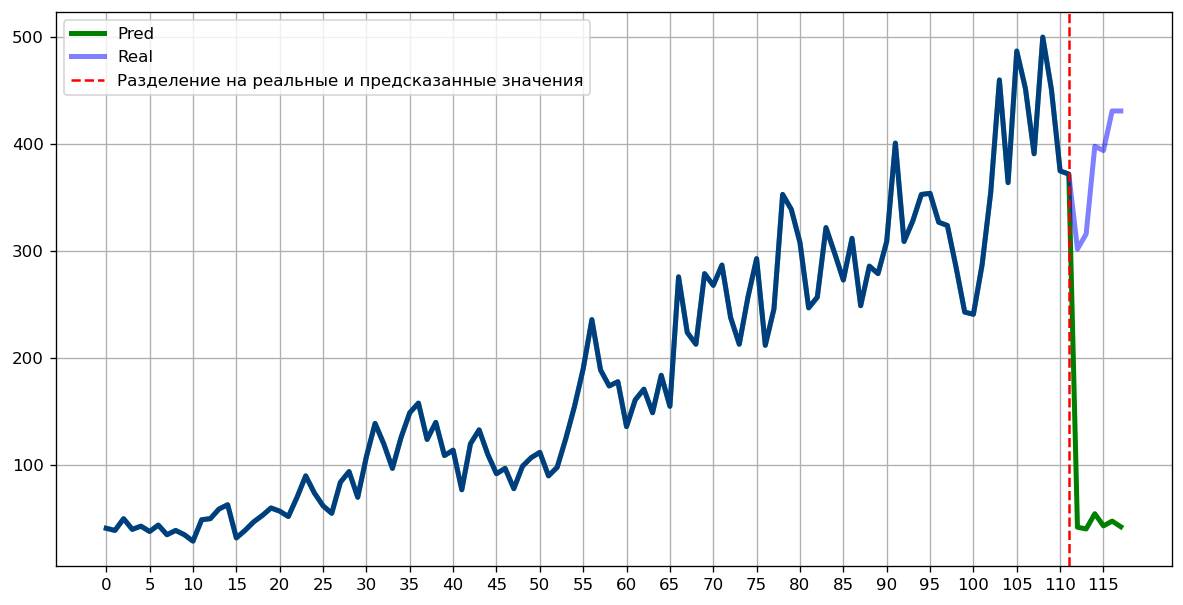

In [ ]:
plot_pred_test(series,pred_series)# предсказанные значеня начинаются со 113

**Стационарный временной ряд**

In [ ]:
st_tes = TripleExponentialSmoothing()

In [ ]:
st_tes.fit(train, 12)

In [ ]:
st_forecast = tes.forecast(len(st_test))

In [ ]:
mean_squared_error(st_test,st_forecast)

3022.972720250244

In [ ]:
st_series_pred = st_train.append(pd.Series(st_forecast), ignore_index=True)

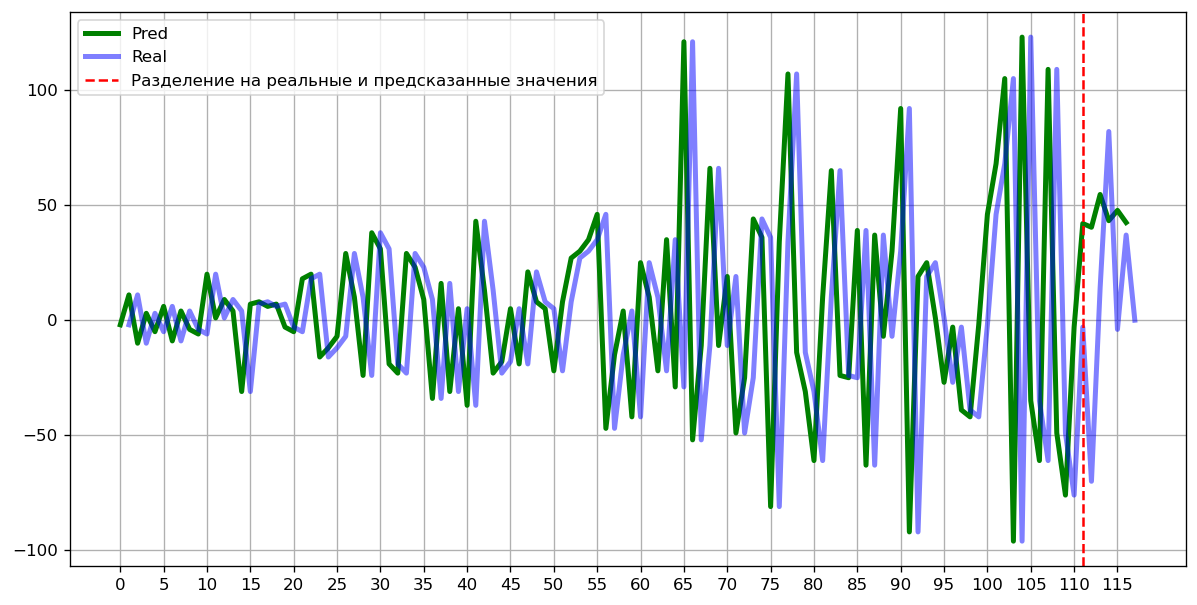

In [ ]:
plot_pred_test(stat_series,st_series_pred)# предсказанные значеня начинаются со 112

#Заключение:

Используя модели реализованные выше, наиболее точно можно предсказать только следующее значение, чем дальше прогноз, тем менее точным он становиться. Для более качественного предсказация лучше использовать модели, которые учитывают большее число параметров,например таких как тренд и сезонность(двойное экспонециальное сглаживание, тройное экспонециальное сглаживание) 